We will fit a simple continuous power law model:
$$
p(x \mid \alpha, x_{\text{min}}) = \frac{\alpha-1}{x_{\text{min}}^{1-\alpha}} x^{-\alpha}.
$$

In [1]:
source("../power_law_aux.r")
library(poweRlaw)
library(rstan)
rstan_options(auto_write = TRUE)

Loading required package: ggplot2
Loading required package: StanHeaders
rstan (Version 2.18.2, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)


Here's the stan code :

In [4]:
writeLines(readLines("../stan/continuous_power_law.stan"))

functions{
    real power_law_lpdf(real x, real a, real m){
     return ( log(a-1)-log(m) -a *( log(x) - log(m)) );
    }
    /*TODO: implement rng for prior and posterior predictive checks*/
}
data{
  int<lower=0> K; // number of unique values  
  real values[K];
  int<lower=0> frequencies[K]; 
  real<lower=0> x_min;
  real<lower=0> alpha_shape;
  real<lower=0> alpha_rate;
}
parameters{
  real <lower=1> alpha;
}
model{
  /*WARNING: I know this distribution is CONTINUOUS and we shouldn't do this, CONCEPTUALLY*/
  /*HOWEVER: computationally, this makes a lot of sense. It is at least as efficient as not compressing*/
  for (k in 1:K) target += frequencies[k] * power_law_lpdf(values[k] | alpha, x_min);
  target += gamma_lpdf(alpha| alpha_shape, alpha_rate);
  // target += log(alpha - 1); // Jeffrey's prior
}


Let's load the compiled model and prepare the data

In [5]:
contplaw <- readRDS("../stan/continuous_power_law.rds")

In [6]:
data("moby")
the.data <- moby
cdata <- compress_data(the.data)
pl.data <- list(
  K = cdata$K,
  values = cdata$v,
  frequencies = cdata$fs,
  x_min = 1,
  alpha_shape = .2,
  alpha_rate = .2
)

In [8]:
posterior.contplaw <- sampling(contplaw, data = pl.data)
posterior.contplaw


SAMPLING FOR MODEL 'continuous_power_law' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 5.8e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.58 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.175376 seconds (Warm-up)
Chain 1:                0.178652 seconds (Sampling)
Chain 1:    

Inference for Stan model: continuous_power_law.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean   sd      2.5%       25%       50%       75%     97.5%
alpha      2.20    0.00 0.01      2.18      2.19      2.20      2.21      2.22
lp__  -31130.03    0.02 0.71 -31132.07 -31130.22 -31129.76 -31129.58 -31129.52
      n_eff Rhat
alpha  1256    1
lp__   1524    1

Samples were drawn using NUTS(diag_e) at Sun Feb 10 14:31:33 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

Now let's annotate the results and compare with maximum likelihood estimation (MLE).

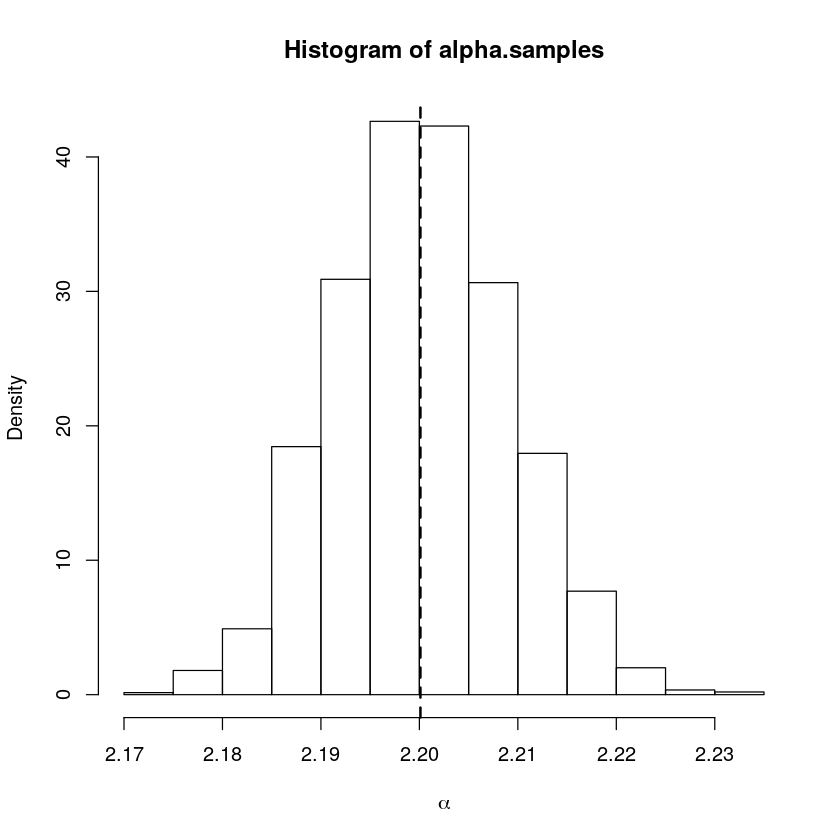

In [10]:
raw <- conpl$new(the.data) 
raw$setXmin(1)
MLE <- estimate_pars(raw)

alpha.samples <- extract(posterior.contplaw, 'alpha')$alpha
hist(alpha.samples, probability = TRUE, xlab = expression(alpha))
abline(v = MLE$pars, lwd = 2, lty = 2)

In [11]:
bridgesampling::bridge_sampler(posterior.contplaw)

Warning message:
“effective sample size cannot be calculated, has been replaced by number of samples.”

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


Bridge sampling estimate of the log marginal likelihood: -31133.53
Estimate obtained in 5 iteration(s) via method "normal".